# Gradient Boosting

## Regression

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class GradientBoostedRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth

        self.trees = []
        self.init_value = None

    def fit(self, X, y):
        self.init_value = np.mean(y)
        y_pred = np.full_like(y, self.init_value, dtype=float)

        # Boosting iterations
        for _ in range(self.n_estimators):
            residuals = y - y_pred # negative gradient
    
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals) # Fit tree to residuals

            update = tree.predict(X)
            y_pred += self.learning_rate * update

            self.trees.append(tree)

    def predict(self, X):
        # Start from initial prediction
        y_pred = np.full(X.shape[0], self.init_value, dtype=float)

        # Add contributions
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)

        return y_pred

    def __call__(self, X):
        return self.predict(X)

In [3]:
from helpers.GetDatasets import regression_split
X_train, X_test, y_train, y_test = regression_split()

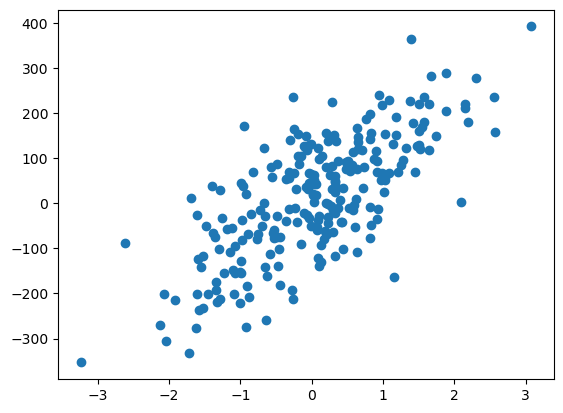

In [4]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:, 0], y_train)

In [5]:
model = GradientBoostedRegressor()
model.fit(X_train, y_train)
preds = model(X_test)

In [6]:
from helpers.MathFunctions import r_squared
r_squared(preds, y_test)

0.8979771540950068

In [7]:
preds = model(X_train)
r_squared(preds, y_train)

0.9907733710251546

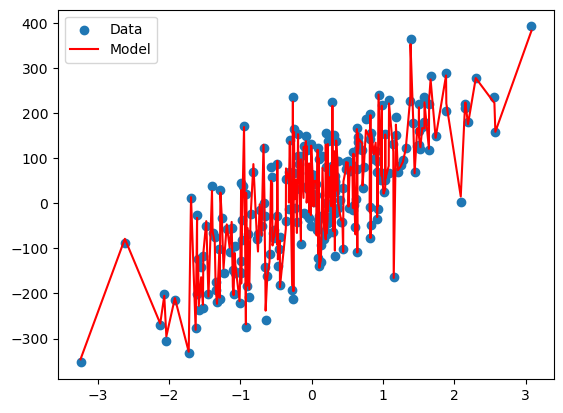

In [9]:
plt.scatter(X_train[:, 0], y_train, label="Data")

idx = np.argsort(X_train[:, 0])
X_sorted = X_train[idx, 0]
y_pred = model.predict(X_train[idx])

plt.plot(X_sorted, y_pred, label="Model", c='r')
plt.legend()
plt.show()

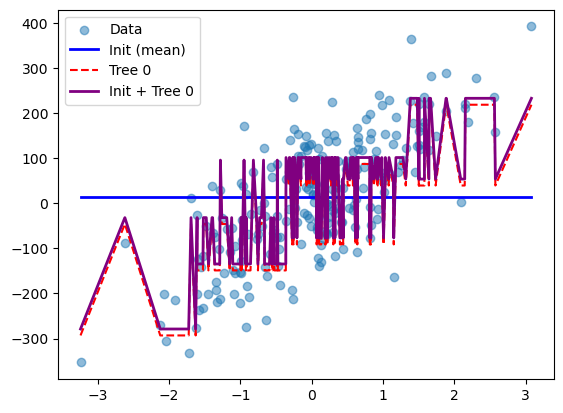

In [10]:
plt.scatter(X_train[:, 0], y_train, label="Data", alpha=0.5)

idx = np.argsort(X_train[:, 0])
X_sorted = X_train[idx, 0]

# Init-only
y_init = np.full_like(X_sorted, model.init_value, dtype=float)
plt.plot(X_sorted, y_init, label="Init (mean)", color="blue", linewidth=2)

# First tree only
y_tree0 = model.trees[0].predict(X_train[idx])
plt.plot(X_sorted, y_tree0, label="Tree 0", color="red", linestyle="--")

# Init + first tree
y_combined = y_init + y_tree0
plt.plot(X_sorted, y_combined, label="Init + Tree 0", color="purple", linewidth=2)

plt.legend()
plt.show()

## Classification

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class GradientBoostedClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth

        self.trees = []
        self.init_logit = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        eps = 1e-6
        p = np.clip(np.mean(y), eps, 1 - eps)
        self.init_logit = np.log(p / (1 - p)) # Initial prediction = log-odds

        F = np.full(X.shape[0], self.init_logit, dtype=float)

        # Boosting itereations
        for _ in range(self.n_estimators):
            p = self._sigmoid(F)
            residuals = y - p # Negative gradient of log loss

            # Fit classification tree to residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Update logits
            F += self.learning_rate * tree.predict(X)

            self.trees.append(tree)

    def predict_logits(self, X):
        F = np.full(X.shape[0], self.init_logit, dtype=float)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        return F

    def predict_proba(self, X):
        logits = self.predict_logits(X)
        return self._sigmoid(logits)
    
    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)
    
    def __call__(self, X):
        return self.predict(X)

In [12]:
from helpers.GetDatasets import classification_split
X_train, X_test, y_train, y_test = classification_split()

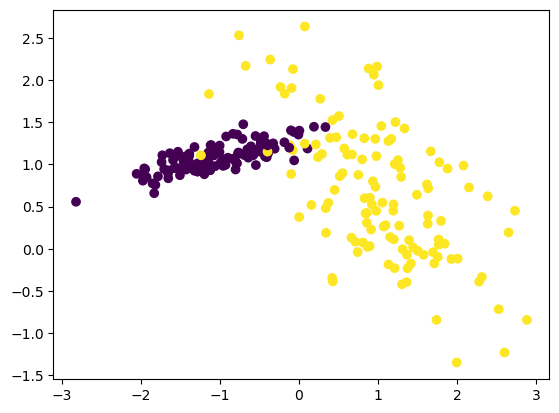

In [13]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

In [14]:
model = GradientBoostedClassifier()
model.fit(X_train, y_train)
preds = model(X_test)

In [15]:
from helpers.Evaluation import classification_stats
cm_args, metrics = classification_stats(preds, y_test)
metrics

{'acc': 0.9666666666666667,
 'precision': 0.967741935483871,
 'recall': 0.967741935483871}

In [16]:
preds = model(X_train)
cm_args, metrics = classification_stats(preds, y_train)
metrics

{'acc': 0.9916666666666667, 'precision': 1.0, 'recall': 0.9833333333333333}

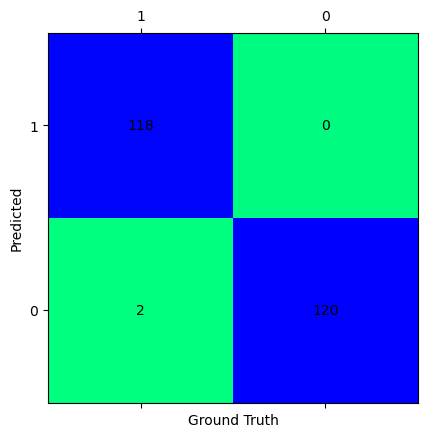

In [17]:
from helpers.Evaluation import confusion_matrix
confusion_matrix(*cm_args)